# Load Dependencies


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os,gzip
from scipy import signal
import pandas as pd
from tqdm import tqdm

# Load Images

In [2]:
start_position=80
end_position=-1
mtx_list = [x for x in os.listdir() if x.endswith('.npy.gz')][start_position:end_position]
img_list=[]
mtx_no_th=[]
#Check threshold file
if os.path.exists('threshold.csv'):
    df = pd.read_csv('threshold.csv')
else:
    raise ValueError('No threshold.csv file')


for i in tqdm(range(len(mtx_list))):
    mtx_name=mtx_list[i]
    if mtx_name in df.name.values:
        with gzip.GzipFile(mtx_name, 'rb') as f:
            mtx=np.load(f)
            kernel = np.outer(signal.windows.gaussian(100, 25),
                      signal.windows.gaussian(100, 25))
            convolv_matrix = signal.fftconvolve(mtx, kernel, mode='same')
            convolv_matrix = convolv_matrix / convolv_matrix.max()
            convolv_matrix[convolv_matrix<0]=0 # assign 0 to value smaller than 0
            img_list.append(convolv_matrix)
    else: 
            mtx_no_th.append(mtx_name)  
#
mtx_with_th = [x for x in mtx_list if x not in mtx_no_th]

print(str(len(mtx_with_th))+' matrix have Threshold')
print(str(len(mtx_no_th))+' matrix have no Threshold')
print('Check mtx_no_th for detailed list of matrix unlabeled')

# Change image list to Numpy
images=np.stack(img_list)

# Getting thresholds
thresholds=[df[df['name']==mtx_name].threshold.values for mtx_name in mtx_with_th]
thresholds=np.array(thresholds)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:43<00:00,  1.36s/it]


32 matrix have Threshold
0 matrix have no Threshold
Check mtx_no_th for detailed list of matrix unlabeled


## **Define Dataset** ##

In [3]:
# Define a custom dataset
class ImageThresholdDataset(Dataset):
    def __init__(self, images, thresholds):
        self.images = images
        self.thresholds = thresholds
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        threshold = self.thresholds[idx]
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(threshold, dtype=torch.float32)


## **Define Model (Basic CNN)** ##

In [4]:

# Define the CNN model
class ThresholdPredictorCNN(nn.Module):
    def __init__(self):
        super(ThresholdPredictorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4) ## Just to speed up, harsh pooling 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3= nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(128 * (images.shape[1] // 64) * (images.shape[2] // 64), 64)
        self.fc2 = nn.Linear(64, 1)


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (images.shape[1] // 64) * (images.shape[2] // 64))
        x = torch.relu(self.fc1(x))
        x =  torch.div(0.5, (1+torch.exp(-self.fc2(x))))
        return x

model = ThresholdPredictorCNN()


In [5]:
class ThresholdLoss(nn.Module):
    def __init__(self):
        super(ThresholdLoss, self).__init__()
        
    def forward(self, y_true, y_pred):
        intersection = torch.sum(y_true * y_pred, dim=[1, 2, 3])
        union = torch.sum(y_true, dim=[1, 2, 3]) + torch.sum(y_pred, dim=[1, 2, 3]) - intersection
        iou = intersection / (union + 1e-6)
        loss = 1 - iou.mean()
        
        return loss

In [5]:
model.load_state_dict(torch.load('Best_CNNModel_NoNegative.pth'))
model.eval()


ThresholdPredictorCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=778752, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

# Use Model for prediction

In [6]:
model.eval()
# Convert numpy array to torch tensor
images = torch.from_numpy(images).float()

# Move the tensor to the appropriate device
device = torch.device( "cpu")
images = images.to(device)

# Ensure your model is also on the same device
model = model.to(device)

# Process each image independently
outputs = []
with torch.no_grad():  # Disable gradient calculation for inference
    for i in tqdm(range(images.shape[0])):
        single_image = images[i, :, :].unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        output = model(single_image)
        outputs.append(output)

# Convert list of outputs to tensor
outputs = torch.cat(outputs, dim=0)

# Print the output
#print(outputs)

100%|██████████| 32/32 [01:02<00:00,  1.94s/it]


In [7]:
outputs_list=outputs.numpy()

In [8]:
msk_true=[img_list[id]>thresholds[id] for id in range(len(img_list))]
CNN_msk_list=[img_list[id]>outputs_list[id] for id in range(len(img_list))]

# Check Your Images! Randomly Select 

Text(0.5, 1.0, 'Predicted vs True Thresholds')

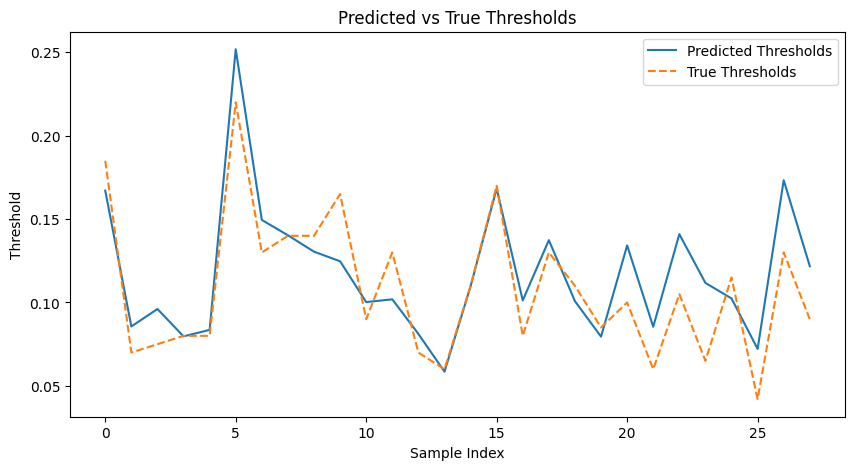

In [11]:

plt.figure(figsize=(10, 5))

plt.plot(outputs_list[thresholds>0], label='Predicted Thresholds')
plt.plot(thresholds[thresholds>0], label='True Thresholds', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Threshold')
plt.legend()
plt.title('Predicted vs True Thresholds')
# plt.show()

In [14]:
np.average(np.sqrt((outputs_list[thresholds>0]-thresholds[thresholds>0])**2))

0.018441204765013288

# Saving The Test


In [20]:
output_folder='CNN_Test_Results'

path = os.path.join(os.getcwd(), output_folder)
if os.path.exists(path):
    print(output_folder+' directory exists')
else: 
    os.mkdir(path)
    
    print("Directory '%s' created" %output_folder) 
    os.chdir(path)
    
    for id in tqdm(range(len(img_list))):
        output_mask=img_list[id]<outputs_list[id]
        # Save the array in a .npy file
        with gzip.GzipFile('CnnMask_'+mtx_list[id], 'w') as f:
            np.save(f, output_mask)

Directory 'CNN_Test_Results' created


100%|████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.64it/s]
